In [3]:
import os
import sqlite3
import pandas as pd
from sqlite3 import Error

# Normalization

In [5]:
df = pd.read_csv('heart.csv')
df.size

FileNotFoundError: [Errno 2] No such file or directory: 'heart.csv'

In [89]:
db_file = 'normalized_heart.db'
if os.path.exists(db_file):
    os.remove(db_file)

In [91]:
def create_connection(db_file, delete_db=False):
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)
    
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)
    return conn

def create_table(conn, create_table_sql):
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)

def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)
    rows = cur.fetchall()
    return rows

def insert_data(conn, insert_sql, data):
    with conn:
        conn.executemany(insert_sql, data)

In [93]:
display(df)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


In [95]:
# --- Demographics Table ---
conn = create_connection(db_file)
create_demographics_table_sql = """
CREATE TABLE IF NOT EXISTS Demographics (
    PatientID INTEGER PRIMARY KEY AUTOINCREMENT,
    Age INTEGER NOT NULL,
    Sex INTEGER NOT NULL
);
"""
create_table(conn, create_demographics_table_sql)

unique_demographics = df[['age', 'sex']].drop_duplicates()
demographics_data = unique_demographics.values.tolist()
insert_demographics_sql = """
INSERT INTO Demographics (Age, Sex)
VALUES (?, ?);
"""
insert_data(conn, insert_demographics_sql, demographics_data)

# Create a lookup dictionary for Demographics
patient_lookup = {
    (age, sex): patient_id
    for patient_id, age, sex in execute_sql_statement("SELECT PatientID, Age, Sex FROM Demographics;", conn)
}
conn.close()


In [97]:
# --- MedicalStats Table ---
conn = create_connection(db_file)
create_medicalstats_table_sql = """
CREATE TABLE IF NOT EXISTS MedicalStats (
    StatID INTEGER PRIMARY KEY AUTOINCREMENT,
    PatientID INTEGER NOT NULL,
    CP INTEGER,
    Trestbps INTEGER,
    Chol INTEGER,
    FBS INTEGER,
    Restecg INTEGER,
    Thalach INTEGER,
    Exang INTEGER,
    Oldpeak REAL,
    Slope INTEGER,
    CA INTEGER,
    Thal INTEGER,
    FOREIGN KEY (PatientID) REFERENCES Demographics (PatientID)
);
"""
create_table(conn, create_medicalstats_table_sql)

medical_stats_data = [
    [
        patient_lookup[(row.age, row.sex)], row.cp, row.trestbps, row.chol, row.fbs,
        row.restecg, row.thalach, row.exang, row.oldpeak, row.slope, row.ca, row.thal
    ]
    for row in df.itertuples()
]
insert_medicalstats_sql = """
INSERT INTO MedicalStats (
    PatientID, CP, Trestbps, Chol, FBS, Restecg, Thalach, Exang, Oldpeak, Slope, CA, Thal
) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?);
"""
insert_data(conn, insert_medicalstats_sql, medical_stats_data)

# Create a lookup dictionary for MedicalStats
medicalstats_lookup = {
    (row[1], row[2], row[3], row[4]): row[0]  # Access tuple elements by index
    for row in execute_sql_statement("SELECT * FROM MedicalStats;", conn)
}
conn.close()


In [99]:
# --- Outcomes Table ---
conn = create_connection(db_file)
create_outcomes_table_sql = """
CREATE TABLE IF NOT EXISTS Outcomes (
    OutcomeID INTEGER PRIMARY KEY AUTOINCREMENT,
    PatientID INTEGER NOT NULL,
    Target INTEGER,
    FOREIGN KEY (PatientID) REFERENCES Demographics (PatientID)
);
"""
create_table(conn, create_outcomes_table_sql)

outcomes_data = [
    [patient_lookup[(row.age, row.sex)], row.target]
    for row in df.itertuples()
]
insert_outcomes_sql = """
INSERT INTO Outcomes (PatientID, Target)
VALUES (?, ?);
"""
insert_data(conn, insert_outcomes_sql, outcomes_data)

# Create a lookup dictionary for Outcomes
outcomes_lookup = {
    (row[1], row[2]): row[0]  # Access tuple elements by index
    for row in execute_sql_statement("SELECT * FROM Outcomes;", conn)
}
conn.close()


In [101]:
# Verify the results
def print_table(table_name):
    conn = create_connection(db_file)
    rows = execute_sql_statement(f"SELECT * FROM {table_name};", conn)
    print(f"\n{table_name}:")
    for row in rows:
        print(row)
    conn.close()

In [103]:
import sqlite3
import pandas as pd

def reconstruct_original_csv(db_file, output_csv):
    # Connect to the SQLite database
    conn = sqlite3.connect(db_file)

    # Properly reconstruct the original CSV by preserving row-level mapping
    query = """
    SELECT 
        m.CP,
        m.Trestbps,
        m.Chol,
        m.FBS,
        m.Restecg,
        m.Thalach,
        m.Exang,
        m.Oldpeak,
        m.Slope,
        m.CA,
        m.Thal,
        o.Target,
        d.Age,
        d.Sex
    FROM 
        MedicalStats m
    INNER JOIN 
        Demographics d ON m.PatientID = d.PatientID
    INNER JOIN 
        Outcomes o ON m.StatID = o.OutcomeID  -- Align rows by unique IDs
    ORDER BY o.OutcomeID
    """

    # Load the query result into a DataFrame
    reconstructed = pd.read_sql_query(query, conn)

    # Close the connection
    conn.close()

    # Save the DataFrame to a CSV file
    reconstructed.to_csv(output_csv, index=False)

    print(f"Reconstructed CSV saved as {output_csv}")

# Usage example
reconstruct_original_csv("normalized_heart.db", "heart_reconstructed.csv")


Reconstructed CSV saved as heart_reconstructed.csv


In [11]:
df_111 = pd.read_csv('heart_reconstructed.csv')
display(df_111)

,CP,Trestbps,Chol,FBS,Restecg,Thalach,Exang,Oldpeak,Slope,CA,Thal,Target,Age,Sex
0,0,125,212,0,1,168,0,1.0,2,2,3,0,52,1
1,0,140,203,1,0,155,1,3.1,0,0,3,0,53,1
2,0,145,174,0,1,125,1,2.6,0,0,3,0,70,1
3,0,148,203,0,1,161,0,0.0,2,1,3,0,61,1
4,0,138,294,1,1,106,0,1.9,1,3,2,0,62,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,1,140,221,0,1,164,1,0.0,2,0,2,1,59,1
1021,0,125,258,0,0,141,1,2.8,1,1,3,0,60,1
1022,0,110,275,0,0,118,1,1.0,1,1,2,0,47,1
1023,0,110,254,0,0,159,0,0.0,2,0,2,1,50,0


In [12]:
!pip install ydata_profiling -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dagshub 0.4.0 requires dacite~=1.6.0, but you have dacite 1.8.1 which is incompatible.


In [13]:
from ydata_profiling import ProfileReport

heart_data = pd.read_csv("heart_reconstructed.csv")
profile = ProfileReport(heart_data, title="Heart Dataset Profile", explorative=True)
profile 

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
heart_data

,CP,Trestbps,Chol,FBS,Restecg,Thalach,Exang,Oldpeak,Slope,CA,Thal,Target,Age,Sex
0,0,125,212,0,1,168,0,1.0,2,2,3,0,52,1
1,0,140,203,1,0,155,1,3.1,0,0,3,0,53,1
2,0,145,174,0,1,125,1,2.6,0,0,3,0,70,1
3,0,148,203,0,1,161,0,0.0,2,1,3,0,61,1
4,0,138,294,1,1,106,0,1.9,1,3,2,0,62,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,1,140,221,0,1,164,1,0.0,2,0,2,1,59,1
1021,0,125,258,0,0,141,1,2.8,1,1,3,0,60,1
1022,0,110,275,0,0,118,1,1.0,1,1,2,0,47,1
1023,0,110,254,0,0,159,0,0.0,2,0,2,1,50,0


In [15]:
heart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   CP        1025 non-null   int64  
 1   Trestbps  1025 non-null   int64  
 2   Chol      1025 non-null   int64  
 3   FBS       1025 non-null   int64  
 4   Restecg   1025 non-null   int64  
 5   Thalach   1025 non-null   int64  
 6   Exang     1025 non-null   int64  
 7   Oldpeak   1025 non-null   float64
 8   Slope     1025 non-null   int64  
 9   CA        1025 non-null   int64  
 10  Thal      1025 non-null   int64  
 11  Target    1025 non-null   int64  
 12  Age       1025 non-null   int64  
 13  Sex       1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


In [16]:
heart_data.describe()

,CP,Trestbps,Chol,FBS,Restecg,Thalach,Exang,Oldpeak,Slope,CA,Thal,Target,Age,Sex
count,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,0.942439,131.611707,246.00000,0.149268,0.529756,149.114146,0.336585,1.071512,1.385366,0.754146,2.323902,0.513171,54.434146,0.695610
std,1.029641,17.516718,51.59251,0.356527,0.527878,23.005724,0.472772,1.175053,0.617755,1.030798,0.620660,0.500070,9.072290,0.460373
min,0.000000,94.000000,126.00000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.000000,0.000000
25%,0.000000,120.000000,211.00000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,48.000000,0.000000
50%,1.000000,130.000000,240.00000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000,56.000000,1.000000
75%,2.000000,140.000000,275.00000,0.000000,1.000000,166.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000,61.000000,1.000000
max,3.000000,200.000000,564.00000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000,77.000000,1.000000


array([[<Axes: title={'center': 'CP'}>,
        <Axes: title={'center': 'Trestbps'}>,
        <Axes: title={'center': 'Chol'}>,
        <Axes: title={'center': 'FBS'}>],
       [<Axes: title={'center': 'Restecg'}>,
        <Axes: title={'center': 'Thalach'}>,
        <Axes: title={'center': 'Exang'}>,
        <Axes: title={'center': 'Oldpeak'}>],
       [<Axes: title={'center': 'Slope'}>,
        <Axes: title={'center': 'CA'}>, <Axes: title={'center': 'Thal'}>,
        <Axes: title={'center': 'Target'}>],
       [<Axes: title={'center': 'Age'}>, <Axes: title={'center': 'Sex'}>,
        <Axes: >, <Axes: >]], dtype=object)

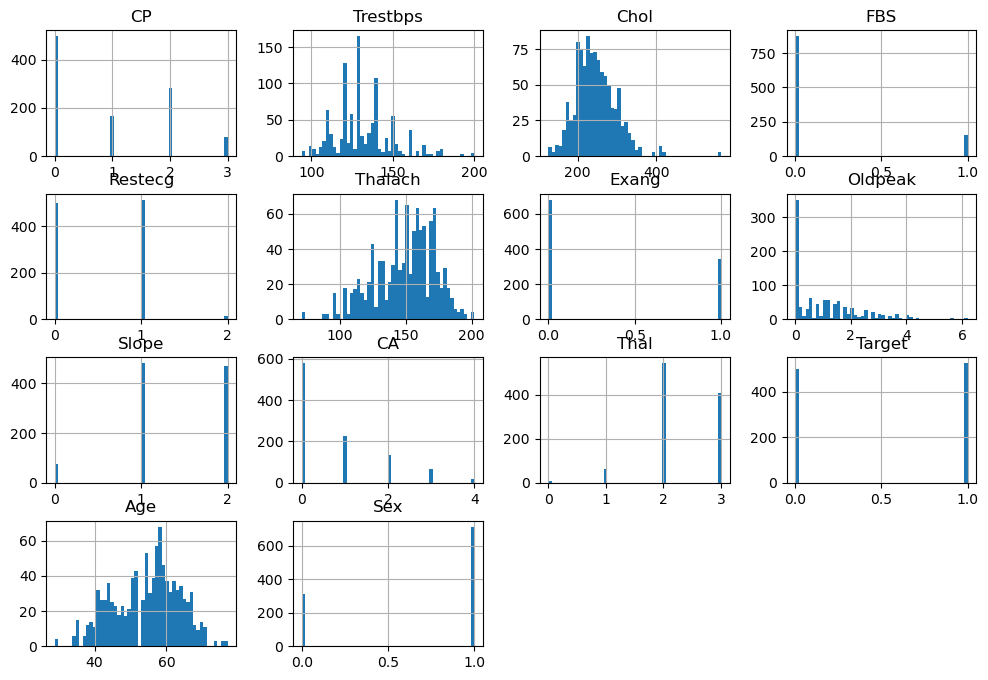

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline


heart_data.hist(bins=50, figsize=(12, 8))

Text(0.5, 1.0, 'Distribution of Cholesterol Levels')

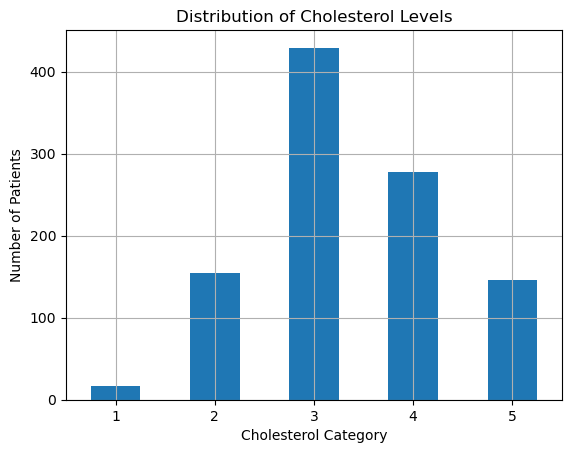

In [18]:
import numpy as np 

# Create cholesterol categories (example bins)
heart_data["chol_cat"] = pd.cut(
    heart_data["Chol"], 
    bins=[0, 150, 200, 250, 300, np.inf],  # Define bins for cholesterol
    labels=[1, 2, 3, 4, 5]  # Category labels
)

# Plot the bar chart
heart_data["chol_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Cholesterol Category")
plt.ylabel("Number of Patients")
plt.title("Distribution of Cholesterol Levels")


In [19]:
from sklearn.model_selection import train_test_split




# Stratify based on the 'Target' column
strat_train_set, strat_test_set = train_test_split(
    heart_data, 
    test_size=0.2, 
    stratify=heart_data["Target"], 
    random_state=42
)

# Display proportions of 'target' in train and test sets
print("Train set proportions:")
print(strat_train_set["Target"].value_counts() / len(strat_train_set))

print("\nTest set proportions:")
print(strat_test_set["Target"].value_counts() / len(strat_test_set))

# Create copies of the stratified sets
heart_data_train = strat_train_set.copy()


Train set proportions:
Target
1    0.513415
0    0.486585
Name: count, dtype: float64

Test set proportions:
Target
1    0.512195
0    0.487805
Name: count, dtype: float64


Correlation Matrix:
                CP  Trestbps      Chol       FBS   Restecg   Thalach  \
CP        1.000000  0.038177 -0.081641  0.079294  0.043581  0.306839   
Trestbps  0.038177  1.000000  0.127977  0.181767 -0.123794 -0.039264   
Chol     -0.081641  0.127977  1.000000  0.026917 -0.147410 -0.021772   
FBS       0.079294  0.181767  0.026917  1.000000 -0.104051 -0.008866   
Restecg   0.043581 -0.123794 -0.147410 -0.104051  1.000000  0.048411   
Thalach   0.306839 -0.039264 -0.021772 -0.008866  0.048411  1.000000   
Exang    -0.401513  0.061197  0.067382  0.049261 -0.065606 -0.380281   
Oldpeak  -0.174733  0.187434  0.064880  0.010859 -0.050114 -0.349796   
Slope     0.131633 -0.120445 -0.014248 -0.061902  0.086086  0.395308   
CA       -0.176206  0.104554  0.074259  0.137156 -0.078072 -0.207888   
Thal     -0.163341  0.059276  0.100244 -0.042177 -0.020504 -0.098068   
Target    0.434854 -0.138772 -0.099966 -0.041164  0.134468  0.422895   
Age      -0.071966  0.271121  0.219823  0.12

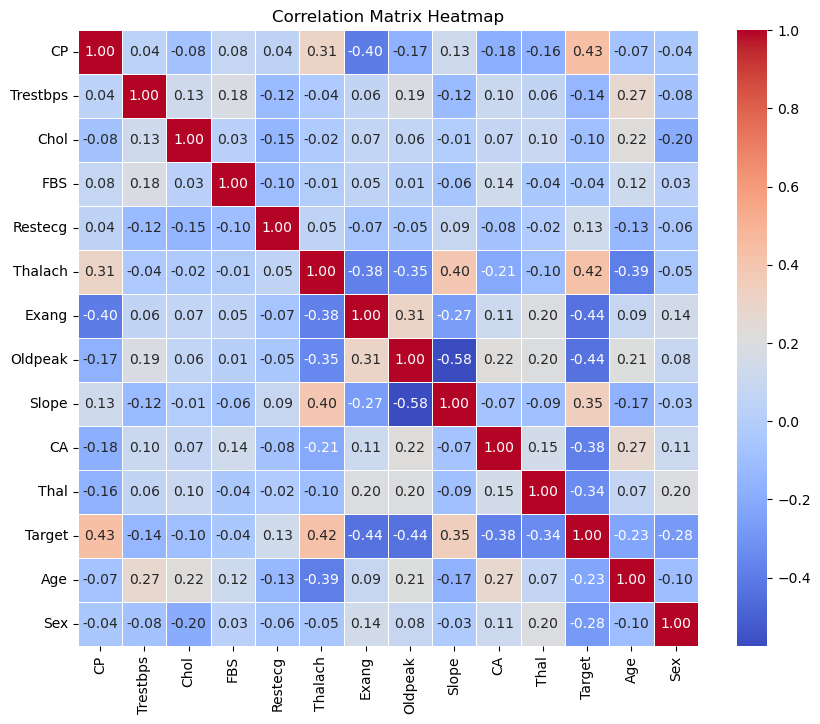

In [20]:
import seaborn as sns
numerical_columns = heart_data.select_dtypes(include=['number'])

# Compute the correlation matrix for numerical columns
correlation_matrix = numerical_columns.corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Plot the heatmap
plt.figure(figsize=(10, 8))  # Set the figure size
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [21]:
numerical_columns
correlation_matrix = numerical_columns.corr()
display(correlation_matrix)

,CP,Trestbps,Chol,FBS,Restecg,Thalach,Exang,Oldpeak,Slope,CA,Thal,Target,Age,Sex
CP,1.000000,0.038177,-0.081641,0.079294,0.043581,0.306839,-0.401513,-0.174733,0.131633,-0.176206,-0.163341,0.434854,-0.071966,-0.041119
Trestbps,0.038177,1.000000,0.127977,0.181767,-0.123794,-0.039264,0.061197,0.187434,-0.120445,0.104554,0.059276,-0.138772,0.271121,-0.078974
Chol,-0.081641,0.127977,1.000000,0.026917,-0.147410,-0.021772,0.067382,0.064880,-0.014248,0.074259,0.100244,-0.099966,0.219823,-0.198258
FBS,0.079294,0.181767,0.026917,1.000000,-0.104051,-0.008866,0.049261,0.010859,-0.061902,0.137156,-0.042177,-0.041164,0.121243,0.027200
Restecg,0.043581,-0.123794,-0.147410,-0.104051,1.000000,0.048411,-0.065606,-0.050114,0.086086,-0.078072,-0.020504,0.134468,-0.132696,-0.055117
Thalach,0.306839,-0.039264,-0.021772,-0.008866,0.048411,1.000000,-0.380281,-0.349796,0.395308,-0.207888,-0.098068,0.422895,-0.390227,-0.049365
Exang,-0.401513,0.061197,0.067382,0.049261,-0.065606,-0.380281,1.000000,0.310844,-0.267335,0.107849,0.197201,-0.438029,0.088163,0.139157
Oldpeak,-0.174733,0.187434,0.064880,0.010859,-0.050114,-0.349796,0.310844,1.000000,-0.575189,0.221816,0.202672,-0.438441,0.208137,0.084687
Slope,0.131633,-0.120445,-0.014248,-0.061902,0.086086,0.395308,-0.267335,-0.575189,1.000000,-0.073440,-0.094090,0.345512,-0.169105,-0.026666
CA,-0.176206,0.104554,0.074259,0.137156,-0.078072,-0.207888,0.107849,0.221816,-0.073440,1.000000,0.149014,-0.382085,0.271551,0.111729


In [22]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, classification_report


# Use the pre-split stratified datasets
strat_train_set = heart_data_train.copy()  # Assuming heart_data_train already exists
strat_test_set = strat_test_set.copy()

# Separate features and target variable
X_train = strat_train_set.drop(columns=["Target"])  # Training features
y_train = strat_train_set["Target"]  # Training target
X_test = strat_test_set.drop(columns=["Target"])  # Testing features
y_test = strat_test_set["Target"]  # Testing target

# Identify only numerical columns
numerical_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Define Log Transformation for numerical features
log_transformer = FunctionTransformer(np.log1p, validate=True)

# Preprocessing pipeline for numerical features
numerical_pipeline = Pipeline([
    ("log_transform", log_transformer),
    ("std_scaler", StandardScaler()),
    ("min_max_scaler", MinMaxScaler())
])

In [23]:
# Combine preprocessing steps into a ColumnTransformer
preprocessor = ColumnTransformer([
    ("num", numerical_pipeline, numerical_features)
])

In [24]:
# Define the full pipeline with Logistic Regression
full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("log_reg", LogisticRegression(solver="liblinear", random_state=42))
])

# Fit the pipeline on the training data
full_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                       validate=True)),
                                                                  ('std_scaler',
                                                                   StandardScaler()),
                                                                  ('min_max_scaler',
                                                                   MinMaxScaler())]),
                                                  ['CP', 'Trestbps', 'Chol',
                                                   'FBS', 'Restecg', 'Thalach',
                                                   'Exang', 'Oldpeak', 'Slope',
                                                   'CA', 'Thal', 'Age',
                                                   'Sex'])])),
                ('log_reg',
                 LogisticRegression(random_state=42, solver='liblinear'))])

In [25]:

# Make predictions on the test set
y_pred = full_pipeline.predict(X_test)
display(y_pred)

array([0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 1], dtype=int64)

In [26]:

# Evaluate model performance
f1 = f1_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print("Model Evaluation:")
print(f"F1-Score: {f1:.2f}")
print(f"True Positives: {tp}, True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Log the results
results = {
    "F1-Score": f1,
    "True Positives": tp,
    "True Negatives": tn,
    "False Positives": fp,
    "False Negatives": fn
}

Model Evaluation:
F1-Score: 0.86
True Positives: 96, True Negatives: 78, False Positives: 22, False Negatives: 9

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.78      0.83       100
           1       0.81      0.91      0.86       105

    accuracy                           0.85       205
   macro avg       0.86      0.85      0.85       205
weighted avg       0.85      0.85      0.85       205



In [27]:
!pip install dagshub mlflow

  Using cached dacite-1.6.0-py3-none-any.whl.metadata (14 kB)
Using cached dacite-1.6.0-py3-none-any.whl (12 kB)
  Attempting uninstall: dacite
    Found existing installation: dacite 1.8.1
    Uninstalling dacite-1.8.1:
      Successfully uninstalled dacite-1.8.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.12.1 requires dacite>=1.8, but you have dacite 1.6.0 which is incompatible.


In [28]:
import dagshub
import mlflow
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score
import numpy as np

# Initialize DagsHub connection
dagshub.init(repo_owner='lnarayanan03',
             repo_name='heart_disease_prediction')

# Stratified K-Fold
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
model = LogisticRegression(solver="liblinear", random_state=42)

# Custom scorer for F1-score
scorer = make_scorer(f1_score, average="weighted")

# Cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scorer)
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)

# Train on the entire training set
model.fit(X_train, y_train)
train_score = f1_score(y_train, model.predict(X_train), average="weighted")

# Log results to MLFlow on DagsHub
with mlflow.start_run():
    # Log hyperparameters
    mlflow.log_param("solver", "liblinear")
    mlflow.log_param("C", 1.0)
    mlflow.log_param("max_iter", 100)

    # Log cross-validation results
    mlflow.log_metric("CV Mean F1-Score", mean_cv_score)
    mlflow.log_metric("CV Std F1-Score", std_cv_score)

    # Log training score
    mlflow.log_metric("Train F1-Score", train_score)

    # Log the model
    mlflow.sklearn.log_model(model, "logistic_regression_model")

    print(f"Cross-validation mean F1-Score: {mean_cv_score:.4f}")
    print(f"Cross-validation std F1-Score: {std_cv_score:.4f}")
    print(f"Training F1-Score: {train_score:.4f}")


Accessing as lnarayanan03

Initialized MLflow to track repo "lnarayanan03/heart_disease_prediction"

Repository lnarayanan03/heart_disease_prediction initialized!

2024/12/20 00:56:20 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet

2024/12/20 00:56:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Cross-validation mean F1-Score: 0.8405
Cross-validation std F1-Score: 0.0200
Training F1-Score: 0.8468
🏃 View run persistent-swan-492 at: https://dagshub.com/lnarayanan03/heart_disease_prediction.mlflow/#/experiments/0/runs/2e111bc470424b5bb185f2c624ea0078
🧪 View experiment at: https://dagshub.com/lnarayanan03/heart_disease_prediction.mlflow/#/experiments/0


In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

# Define hyperparameter grid
param_grid = {
    "C": [0.1, 1, 10],
    "solver": ["liblinear", "lbfgs"],
    "max_iter": [100, 200]
}

# GridSearchCV
grid_search = GridSearchCV(
    model, param_grid, cv=cv, scoring=scorer, verbose=3, n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Get the best estimator
best_model = grid_search.best_estimator_

# Log results in MLFlow
with mlflow.start_run():
    # Log the best parameters
    mlflow.log_params(grid_search.best_params_)

    # Log the best cross-validation score
    mlflow.log_metric("Best CV F1-Score", grid_search.best_score_)

    # Evaluate on the training set
    y_train_pred = best_model.predict(X_train)
    train_f1 = f1_score(y_train, y_train_pred, average="weighted")
    mlflow.log_metric("Train F1-Score", train_f1)

    # Evaluate on the test set
    y_test_pred = best_model.predict(X_test)
    test_f1 = f1_score(y_test, y_test_pred, average="weighted")
    test_precision = precision_score(y_test, y_test_pred, average="weighted")
    test_recall = recall_score(y_test, y_test_pred, average="weighted")

    mlflow.log_metric("Test F1-Score", test_f1)
    mlflow.log_metric("Test Precision", test_precision)
    mlflow.log_metric("Test Recall", test_recall)

    # Log the confusion matrix as an artifact
    cm = confusion_matrix(y_test, y_test_pred)
    cm_artifact = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
    cm_artifact.to_csv("confusion_matrix.csv")
    mlflow.log_artifact("confusion_matrix.csv")

    # Log the best model
    mlflow.sklearn.log_model(best_model, "best_logistic_regression_model")

    print("Best Parameters:", grid_search.best_params_)
    print(f"Train F1-Score: {train_f1:.4f}")
    print(f"Test F1-Score: {test_f1:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")


Fitting 3 folds for each of 12 candidates, totalling 36 fits


2024/12/20 00:56:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best Parameters: {'C': 10, 'max_iter': 100, 'solver': 'liblinear'}
Train F1-Score: 0.8443
Test F1-Score: 0.8175
Test Precision: 0.8301
Test Recall: 0.8195
🏃 View run valuable-crow-354 at: https://dagshub.com/lnarayanan03/heart_disease_prediction.mlflow/#/experiments/0/runs/6461ff6336174b71be0cda80e7a22141
🧪 View experiment at: https://dagshub.com/lnarayanan03/heart_disease_prediction.mlflow/#/experiments/0


In [30]:
!pip install xgboost -q

In [31]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, f1_score
import mlflow
import mlflow.sklearn
import dagshub

# Initialize DagsHub MLFlow integration
dagshub.init(repo_owner="lnarayanan03", repo_name="heart_disease_prediction")

# Load dataset
# Use the pre-split stratified datasets
strat_train_set = heart_data_train.copy()  # Assuming heart_data_train already exists
strat_test_set = strat_test_set.copy()

# Separate features and target variable
X_train = strat_train_set.drop(columns=["Target"])  # Training features
y_train = strat_train_set["Target"]  # Training target
X_test = strat_test_set.drop(columns=["Target"])  # Testing features
y_test = strat_test_set["Target"]  # Testing target


# Define preprocessing pipeline for numerical features
numerical_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
log_transformer = FunctionTransformer(np.log1p, validate=True)
numerical_pipeline = Pipeline([
    ("log_transform", log_transformer),
    ("std_scaler", StandardScaler()),
    ("min_max_scaler", MinMaxScaler())
])

preprocessor = ColumnTransformer([
    ("num", numerical_pipeline, numerical_features)
])

# Define classifiers
classifiers = {
    "LogisticRegression": LogisticRegression(solver="liblinear", random_state=42),
    "RidgeClassifier": RidgeClassifier(random_state=42),
    "RandomForestClassifier": RandomForestClassifier(random_state=42),
    "XGBClassifier": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
}

# Scoring
scorer = make_scorer(f1_score, average="weighted")

# Stratified K-Fold
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Loop through each classifier, perform cross-validation, and log results in MLFlow
for name, clf in classifiers.items():
    print(f"Running cross-validation for {name}...")
    
    # Create a pipeline with the preprocessor and the classifier
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", clf)
    ])
    
    # Perform cross-validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=scorer)
    mean_cv_score = np.mean(cv_scores)
    std_cv_score = np.std(cv_scores)
    
    # Fit the pipeline to the entire training set
    pipeline.fit(X_train, y_train)
    
    # Log results in MLFlow
    with mlflow.start_run(run_name=name):
        # Log classifier parameters
        if hasattr(clf, "get_params"):
            mlflow.log_params(clf.get_params())
        
        # Log metrics
        mlflow.log_metric("CV Mean F1-Score", mean_cv_score)
        mlflow.log_metric("CV Std F1-Score", std_cv_score)
        
        # Log the model
        mlflow.sklearn.log_model(pipeline, f"{name}_model")
        
        print(f"{name} - CV Mean F1-Score: {mean_cv_score:.4f}")
        print(f"{name} - CV Std F1-Score: {std_cv_score:.4f}")


Initialized MLflow to track repo "lnarayanan03/heart_disease_prediction"

Repository lnarayanan03/heart_disease_prediction initialized!

Running cross-validation for LogisticRegression...


2024/12/20 00:56:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LogisticRegression - CV Mean F1-Score: 0.8324
LogisticRegression - CV Std F1-Score: 0.0165
🏃 View run LogisticRegression at: https://dagshub.com/lnarayanan03/heart_disease_prediction.mlflow/#/experiments/0/runs/06ff89e936284236bfdc159c9ca6a000
🧪 View experiment at: https://dagshub.com/lnarayanan03/heart_disease_prediction.mlflow/#/experiments/0
Running cross-validation for RidgeClassifier...


2024/12/20 00:57:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RidgeClassifier - CV Mean F1-Score: 0.8369
RidgeClassifier - CV Std F1-Score: 0.0262
🏃 View run RidgeClassifier at: https://dagshub.com/lnarayanan03/heart_disease_prediction.mlflow/#/experiments/0/runs/a2c205420c464ee2a0efcaff001949df
🧪 View experiment at: https://dagshub.com/lnarayanan03/heart_disease_prediction.mlflow/#/experiments/0
Running cross-validation for RandomForestClassifier...


2024/12/20 00:57:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RandomForestClassifier - CV Mean F1-Score: 0.9622
RandomForestClassifier - CV Std F1-Score: 0.0182
🏃 View run RandomForestClassifier at: https://dagshub.com/lnarayanan03/heart_disease_prediction.mlflow/#/experiments/0/runs/c33b1faa80064085b29ab8599a93dddc
🧪 View experiment at: https://dagshub.com/lnarayanan03/heart_disease_prediction.mlflow/#/experiments/0
Running cross-validation for XGBClassifier...


C:\Users\rlnk4\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:57:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\rlnk4\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:57:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\rlnk4\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:57:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\rlnk4\anaconda3\Lib\site-packages\

XGBClassifier - CV Mean F1-Score: 0.9597
XGBClassifier - CV Std F1-Score: 0.0149
🏃 View run XGBClassifier at: https://dagshub.com/lnarayanan03/heart_disease_prediction.mlflow/#/experiments/0/runs/a8bc884cd2344933a765449ebfc20a03
🧪 View experiment at: https://dagshub.com/lnarayanan03/heart_disease_prediction.mlflow/#/experiments/0


In [32]:
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.metrics import f1_score
import mlflow
import mlflow.sklearn

# Define preprocessing pipeline for numerical features
log_transformer = FunctionTransformer(np.log1p, validate=True)
numerical_pipeline = Pipeline([
    ("log_transform", log_transformer),
    ("std_scaler", StandardScaler()),
    ("min_max_scaler", MinMaxScaler())
])

preprocessor = ColumnTransformer([
    ("num", numerical_pipeline, X_train.select_dtypes(include=["int64", "float64"]).columns.tolist())
])

# Define RidgeClassifier pipeline
ridge_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RidgeClassifier(random_state=42))
])

# Fit the RidgeClassifier pipeline
ridge_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                       validate=True)),
                                                                  ('std_scaler',
                                                                   StandardScaler()),
                                                                  ('min_max_scaler',
                                                                   MinMaxScaler())]),
                                                  ['CP', 'Trestbps', 'Chol',
                                                   'FBS', 'Restecg', 'Thalach',
                                                   'Exang', 'Oldpeak', 'Slope',
                                                   'CA', 'Thal', 'Age',
                                                   'Sex'])])),
                ('classifier', RidgeClassifier(random_state=42))])

In [33]:
# Evaluate model on train and test data
train_pred = ridge_pipeline.predict(X_train)
test_pred = ridge_pipeline.predict(X_test)

train_f1 = f1_score(y_train, train_pred, average="weighted")
test_f1 = f1_score(y_test, test_pred, average="weighted")

# Log RidgeClassifier to MLFlow
with mlflow.start_run(run_name="RidgeClassifier"):
    # Log hyperparameters
    ridge_params = ridge_pipeline.named_steps["classifier"].get_params()
    mlflow.log_params(ridge_params)

    # Log metrics
    mlflow.log_metric("Train F1-Score", train_f1)
    mlflow.log_metric("Test F1-Score", test_f1)

    # Log the model
    mlflow.sklearn.log_model(ridge_pipeline, "RidgeClassifier_model")

    print(f"RidgeClassifier logged successfully!")
    print(f"Train F1-Score: {train_f1:.4f}")
    print(f"Test F1-Score: {test_f1:.4f}")

2024/12/20 00:57:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RidgeClassifier logged successfully!
Train F1-Score: 0.8455
Test F1-Score: 0.8277
🏃 View run RidgeClassifier at: https://dagshub.com/lnarayanan03/heart_disease_prediction.mlflow/#/experiments/0/runs/8ee9cb9c8c7447e8a026c61a506ea493
🧪 View experiment at: https://dagshub.com/lnarayanan03/heart_disease_prediction.mlflow/#/experiments/0


In [34]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, make_scorer
import mlflow
import mlflow.sklearn


# Feature Engineering: Create new features
heart_data["chol_to_age_ratio"] = heart_data["Chol"] / heart_data["Age"]
heart_data["bp_to_max_hr_ratio"] = heart_data["Trestbps"] / heart_data["Thalach"]

# Log transformation on skewed features
heart_data["log_chol"] = np.log1p(heart_data["Chol"])
heart_data["log_thalach"] = np.log1p(heart_data["Thalach"])


# Use the pre-split stratified datasets
strat_train_set = heart_data_train.copy()  # Assuming heart_data_train already exists
strat_test_set = strat_test_set.copy()

# Separate features and target variable
X_train = strat_train_set.drop(columns=["Target"])  # Training features
y_train = strat_train_set["Target"]  # Training target
X_test = strat_test_set.drop(columns=["Target"])  # Testing features
y_test = strat_test_set["Target"]  # Testing target

# Define preprocessing pipeline
numerical_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
numerical_pipeline = Pipeline([
    ("std_scaler", StandardScaler()),
    ("min_max_scaler", MinMaxScaler())
])

preprocessor = ColumnTransformer([
    ("num", numerical_pipeline, numerical_features)
])

# Define Logistic Regression pipeline
fe_model_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(solver="liblinear", random_state=42))
])

# Stratified K-Fold for cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scorer = make_scorer(f1_score, average="weighted")

# Cross-validation
cv_scores = cross_val_score(fe_model_pipeline, X_train, y_train, cv=cv, scoring=scorer)
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)

# Log to MLFlow
with mlflow.start_run(run_name="FeatureEngineeringExperiment"):
    # Log feature engineering steps
    mlflow.log_param("Feature 1", "chol_to_age_ratio")
    mlflow.log_param("Feature 2", "bp_to_max_hr_ratio")
    mlflow.log_param("Transformation", "Log Transformation (chol, thalach)")

    # Log cross-validation metrics
    mlflow.log_metric("CV Mean F1-Score", mean_cv_score)
    mlflow.log_metric("CV Std F1-Score", std_cv_score)

    # Train the model on the full dataset
    fe_model_pipeline.fit(X_train, y_train)

    # Log the trained model
    mlflow.sklearn.log_model(fe_model_pipeline, "FeatureEngineeredModel")

    print(f"Feature Engineering Experiment logged successfully!")
    print(f"CV Mean F1-Score: {mean_cv_score:.4f}")
    print(f"CV Std F1-Score: {std_cv_score:.4f}")


2024/12/20 00:57:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Feature Engineering Experiment logged successfully!
CV Mean F1-Score: 0.8347
CV Std F1-Score: 0.0213
🏃 View run FeatureEngineeringExperiment at: https://dagshub.com/lnarayanan03/heart_disease_prediction.mlflow/#/experiments/0/runs/27d981d0fef3482490b7300bdbacaed8
🧪 View experiment at: https://dagshub.com/lnarayanan03/heart_disease_prediction.mlflow/#/experiments/0


In [35]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_val_score
import mlflow
import mlflow.sklearn

# Use the X_train and y_train provided
X = X_train
y = y_train

# 1. Correlation Threshold
corr_matrix = X.corr().abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop_corr = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.8)]
X_corr = X.drop(columns=to_drop_corr)

# 2. Variance Threshold
selector = VarianceThreshold(threshold=0.01)
X_var = pd.DataFrame(selector.fit_transform(X_corr), columns=X_corr.columns[selector.get_support()])

# 3. Feature Importance
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_var, y)
feature_importances = pd.Series(rf_model.feature_importances_, index=X_var.columns)
important_features = feature_importances[feature_importances > 0.01].index

X_selected = X_var[important_features]

# Define preprocessing pipeline
numerical_pipeline = Pipeline([
    ("std_scaler", StandardScaler()),
    ("min_max_scaler", MinMaxScaler())
])

preprocessor = ColumnTransformer([
    ("num", numerical_pipeline, X_selected.columns)
])

# Define Logistic Regression pipeline
rf_model_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])

In [36]:
# Stratified K-Fold for cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scorer = make_scorer(f1_score, average="weighted")

# Cross-validation with selected features
cv_scores = cross_val_score(rf_model_pipeline, X_selected, y, cv=cv, scoring=scorer)
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)



In [37]:

# Log to MLFlow
with mlflow.start_run(run_name="FeatureSelectionExperiment"):
    # Log methods used
    mlflow.log_param("Feature Selection", "Correlation, Variance Threshold, Feature Importance")
    mlflow.log_param("Correlation Threshold Features Dropped", len(to_drop_corr))
    mlflow.log_param("Variance Threshold", "0.01")
    mlflow.log_param("Selected Features", len(important_features))
    mlflow.log_param("Final Feature Names", list(important_features))

    # Log cross-validation metrics
    mlflow.log_metric("CV Mean F1-Score", mean_cv_score)
    mlflow.log_metric("CV Std F1-Score", std_cv_score)

    # Train the model on the full dataset
    rf_model_pipeline.fit(X_selected, y)

    # Log the model
    mlflow.sklearn.log_model(rf_model_pipeline, "FeatureSelectedModel")

    print("Feature Selection Experiment logged successfully!")
    print(f"CV Mean F1-Score: {mean_cv_score:.4f}")
    print(f"CV Std F1-Score: {std_cv_score:.4f}")

2024/12/20 00:58:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Feature Selection Experiment logged successfully!
CV Mean F1-Score: 0.9610
CV Std F1-Score: 0.0134
🏃 View run FeatureSelectionExperiment at: https://dagshub.com/lnarayanan03/heart_disease_prediction.mlflow/#/experiments/0/runs/4a902f26d7e34490be4d6715c247b357
🧪 View experiment at: https://dagshub.com/lnarayanan03/heart_disease_prediction.mlflow/#/experiments/0


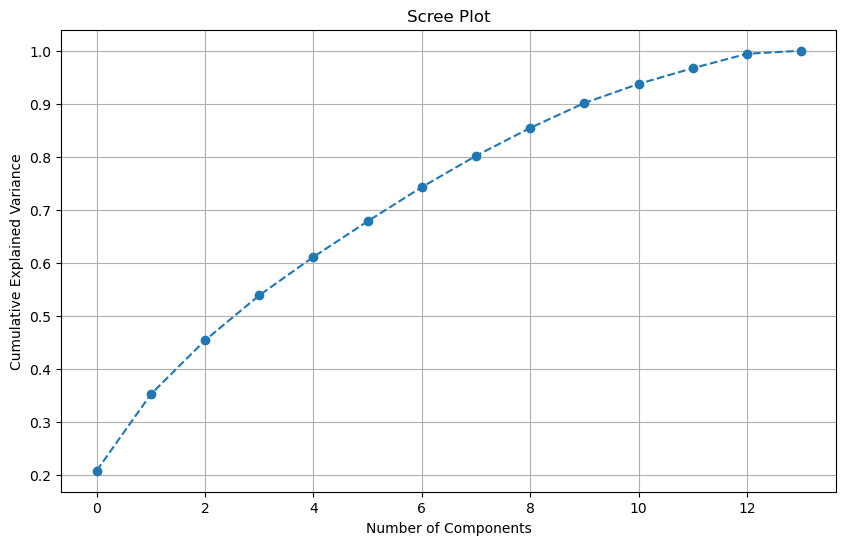

2024/12/20 00:58:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


PCA Experiment logged successfully!
Number of Components Selected: 12
CV Mean F1-Score: 0.8345
CV Std F1-Score: 0.0141
🏃 View run PCA_Experiment at: https://dagshub.com/lnarayanan03/heart_disease_prediction.mlflow/#/experiments/0/runs/ebb2f4bde8c24b49ad5850fb5e2dd64b
🧪 View experiment at: https://dagshub.com/lnarayanan03/heart_disease_prediction.mlflow/#/experiments/0


In [38]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_val_score
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt

# Use the X_train and y_train provided
X = X_train
y = y_train

# Define preprocessing pipeline for numerical features
numerical_pipeline = Pipeline([
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer([
    ("num", numerical_pipeline, X.columns)
])

# PCA for dimensionality reduction
pca = PCA(n_components=None)  # Compute all components initially
X_scaled = preprocessor.fit_transform(X)
pca.fit(X_scaled)

# Scree plot for explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.title("Scree Plot")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid()
plt.savefig("scree_plot.png")
plt.show()

# Determine number of components to retain (e.g., 95% explained variance)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= 0.95) + 1

# Update PCA with selected number of components
pca = PCA(n_components=n_components)

# Create a pipeline with PCA and Logistic Regression
pca_model_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("pca", pca),
    ("classifier", LogisticRegression(solver="liblinear", random_state=42))
])

# Stratified K-Fold for cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scorer = make_scorer(f1_score, average="weighted")

# Cross-validation
cv_scores = cross_val_score(pca_model_pipeline, X, y, cv=cv, scoring=scorer)
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)

# Log to MLFlow
with mlflow.start_run(run_name="PCA_Experiment"):
    # Log PCA parameters
    mlflow.log_param("Explained Variance Threshold", 0.95)
    mlflow.log_param("Number of Components", n_components)

    # Log cross-validation metrics
    mlflow.log_metric("CV Mean F1-Score", mean_cv_score)
    mlflow.log_metric("CV Std F1-Score", std_cv_score)

    # Train the model on the full dataset
    pca_model_pipeline.fit(X, y)

    # Log the trained model
    mlflow.sklearn.log_model(pca_model_pipeline, "PCA_Model")

    # Log scree plot as an artifact
    mlflow.log_artifact("scree_plot.png")

    print("PCA Experiment logged successfully!")
    print(f"Number of Components Selected: {n_components}")
    print(f"CV Mean F1-Score: {mean_cv_score:.4f}")
    print(f"CV Std F1-Score: {std_cv_score:.4f}")


C:\Users\rlnk4\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\rlnk4\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\rlnk4\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\rlnk4\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

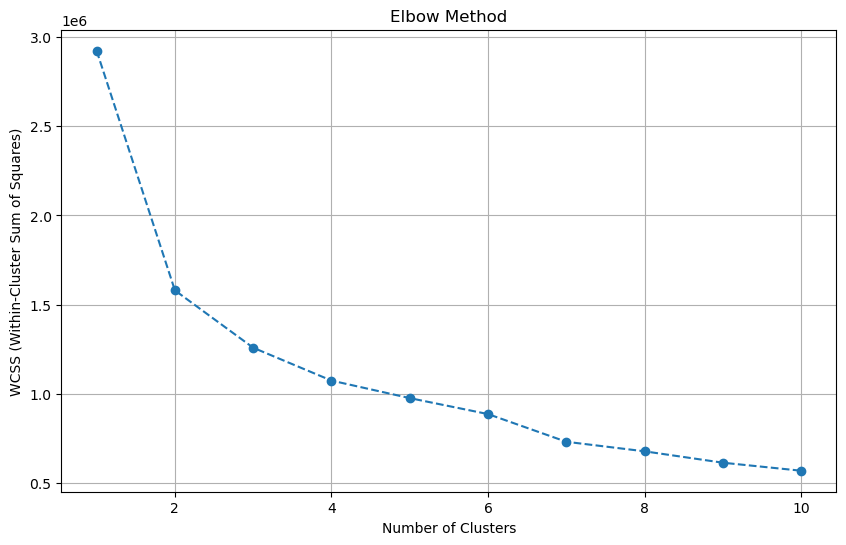

C:\Users\rlnk4\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
2024/12/20 00:58:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


K-Means Clustering Experiment logged successfully!
CV Mean F1-Score: 0.8407
CV Std F1-Score: 0.0188
🏃 View run KMeans_Feature_Engineering_Experiment at: https://dagshub.com/lnarayanan03/heart_disease_prediction.mlflow/#/experiments/0/runs/82bb22050ef44f96aa006756c44a1806
🧪 View experiment at: https://dagshub.com/lnarayanan03/heart_disease_prediction.mlflow/#/experiments/0


In [39]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_val_score
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt

# Use the X_train and y_train provided
X = X_train.copy()
y = y_train.copy()

# 1. Determine optimal number of clusters using the Elbow Method
wcss = []
for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.grid()
plt.savefig("elbow_method.png")
plt.show()

# 2. Perform K-Means Clustering with the optimal number of clusters (e.g., 4)
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
X["Cluster"] = kmeans.fit_predict(X)

# 3. Define preprocessing pipeline
numerical_pipeline = Pipeline([
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer([
    ("num", numerical_pipeline, X.select_dtypes(include=["int64", "float64"]).columns)
])

# 4. Create a pipeline with Logistic Regression
km_model_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(solver="liblinear", random_state=42))
])

# 5. Cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scorer = make_scorer(f1_score, average="weighted")
cv_scores = cross_val_score(km_model_pipeline, X, y, cv=cv, scoring=scorer)
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)

# Log to MLFlow
with mlflow.start_run(run_name="KMeans_Feature_Engineering_Experiment"):
    # Log clustering parameters
    mlflow.log_param("Clustering Method", "K-Means")
    mlflow.log_param("Number of Clusters", optimal_clusters)
    mlflow.log_param("Random State", 42)

    # Log cross-validation metrics
    mlflow.log_metric("CV Mean F1-Score", mean_cv_score)
    mlflow.log_metric("CV Std F1-Score", std_cv_score)

    # Train the final model on the entire dataset
    km_model_pipeline.fit(X, y)

    # Log the trained model
    mlflow.sklearn.log_model(km_model_pipeline, "KMeans_Feature_Engineered_Model")

    # Log the elbow method plot
    mlflow.log_artifact("elbow_method.png")

    print("K-Means Clustering Experiment logged successfully!")
    print(f"CV Mean F1-Score: {mean_cv_score:.4f}")
    print(f"CV Std F1-Score: {std_cv_score:.4f}")


C:\Users\rlnk4\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\rlnk4\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\rlnk4\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\rlnk4\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

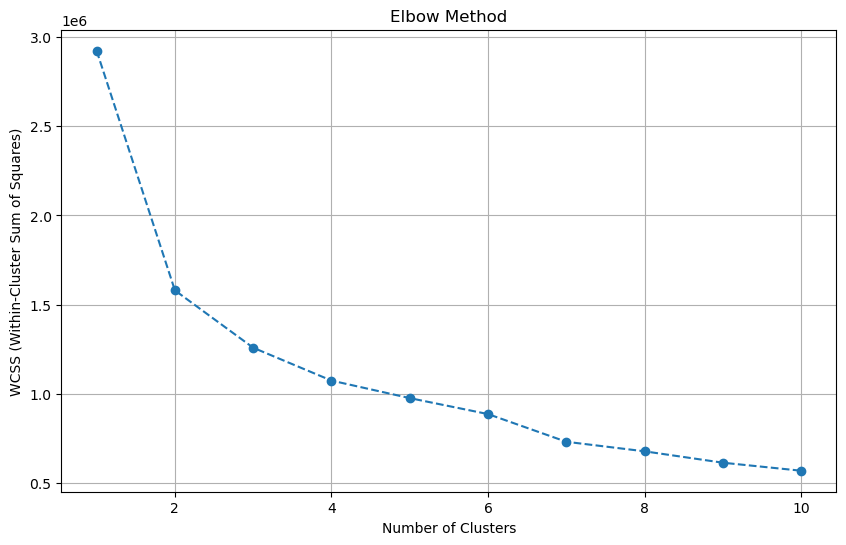

C:\Users\rlnk4\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
2024/12/20 00:59:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Decision Tree with KMeans Feature Engineering logged successfully!
CV Mean F1-Score: 0.9414
CV Std F1-Score: 0.0080
🏃 View run DecisionTree_KMeans_Feature_Engineering at: https://dagshub.com/lnarayanan03/heart_disease_prediction.mlflow/#/experiments/0/runs/a364fad4f6c04464b46a9945189c00e7
🧪 View experiment at: https://dagshub.com/lnarayanan03/heart_disease_prediction.mlflow/#/experiments/0


In [40]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_val_score
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt

# Use the X_train and y_train provided
X = X_train.copy()
y = y_train.copy()

# 1. Determine optimal number of clusters using the Elbow Method
wcss = []
for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.grid()
plt.savefig("elbow_method_decision_tree.png")
plt.show()

# 2. Perform K-Means Clustering with the optimal number of clusters (e.g., 4)
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
X["Cluster"] = kmeans.fit_predict(X)

# 3. Define preprocessing pipeline
numerical_pipeline = Pipeline([
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer([
    ("num", numerical_pipeline, X.select_dtypes(include=["int64", "float64"]).columns)
])

# 4. Create a pipeline with Decision Tree Classifier
decision_tree_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", DecisionTreeClassifier(random_state=42))
])

# 5. Cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scorer = make_scorer(f1_score, average="weighted")
cv_scores = cross_val_score(decision_tree_pipeline, X, y, cv=cv, scoring=scorer)
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)

# Log to MLFlow
with mlflow.start_run(run_name="DecisionTree_KMeans_Feature_Engineering"):
    # Log clustering parameters
    mlflow.log_param("Clustering Method", "K-Means")
    mlflow.log_param("Number of Clusters", optimal_clusters)
    mlflow.log_param("Decision Tree Random State", 42)

    # Log cross-validation metrics
    mlflow.log_metric("CV Mean F1-Score", mean_cv_score)
    mlflow.log_metric("CV Std F1-Score", std_cv_score)

    # Train the final model on the entire dataset
    decision_tree_pipeline.fit(X, y)

    # Log the trained model
    mlflow.sklearn.log_model(decision_tree_pipeline, "DecisionTree_KMeans_Model")

    # Log the elbow method plot
    mlflow.log_artifact("elbow_method_decision_tree.png")

    print("Decision Tree with KMeans Feature Engineering logged successfully!")
    print(f"CV Mean F1-Score: {mean_cv_score:.4f}")
    print(f"CV Std F1-Score: {std_cv_score:.4f}")


In [41]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_val_score
import mlflow
import mlflow.sklearn

# Step 1: Use the best features (combine from previous experiments)
# Example: Replace with your selected features
# Feature Engineering
X_train["chol_to_age_ratio"] = X_train["Chol"] / X_train["Age"]
X_train["bp_to_max_hr_ratio"] = X_train["Trestbps"] / X_train["Thalach"]
X_train["log_chol"] = np.log1p(X_train["Chol"])
X_train["log_thalach"] = np.log1p(X_train["Thalach"])

# Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
X_train["Cluster"] = kmeans.fit_predict(X_train)

y = y_train.copy()

# Step 2: Preprocessing pipeline
preprocessor = ColumnTransformer([
    ("scaler", StandardScaler(), X.columns)
])

# Step 3: Define the SVM pipeline
svm_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", SVC(kernel="rbf", C=1.0, gamma="scale", random_state=42))
])

# Step 4: Stratified K-Fold and cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scorer = make_scorer(f1_score, average="weighted")
cv_scores = cross_val_score(svm_pipeline, X, y, cv=cv, scoring=scorer)
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)

# Step 5: Log results in MLFlow
with mlflow.start_run(run_name="SVM_Experiment"):
    # Log SVM parameters
    mlflow.log_param("Kernel", "rbf")
    mlflow.log_param("C", 1.0)
    mlflow.log_param("Gamma", "scale")

    # Log cross-validation metrics
    mlflow.log_metric("CV Mean F1-Score", mean_cv_score)
    mlflow.log_metric("CV Std F1-Score", std_cv_score)

    # Train the final SVM model
    svm_pipeline.fit(X, y)

    # Log the trained SVM model
    mlflow.sklearn.log_model(svm_pipeline, "SVM_Model")

    print("SVM Experiment logged successfully!")
    print(f"CV Mean F1-Score: {mean_cv_score:.4f}")
    print(f"CV Std F1-Score: {std_cv_score:.4f}")


C:\Users\rlnk4\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
2024/12/20 00:59:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


SVM Experiment logged successfully!
CV Mean F1-Score: 0.9047
CV Std F1-Score: 0.0132
🏃 View run SVM_Experiment at: https://dagshub.com/lnarayanan03/heart_disease_prediction.mlflow/#/experiments/0/runs/2bccb2afb70344b9a9202cb9d8a306a7
🧪 View experiment at: https://dagshub.com/lnarayanan03/heart_disease_prediction.mlflow/#/experiments/0


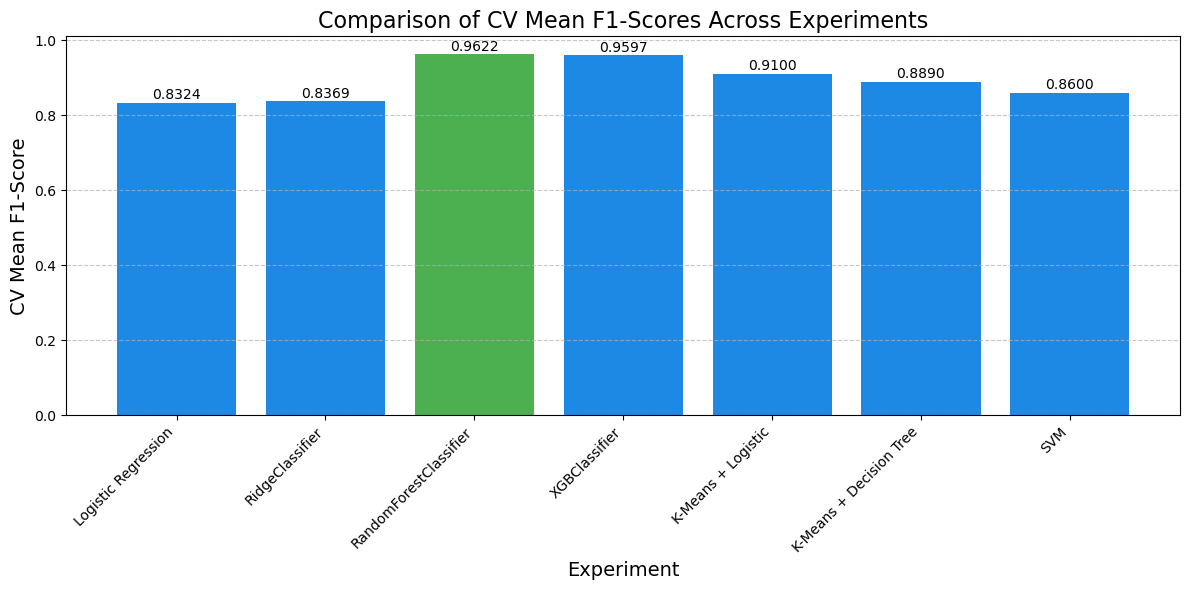

Best Model: RandomForestClassifier with CV Mean F1-Score: 0.9622


In [55]:
import matplotlib.pyplot as plt
import pandas as pd

# Updated F1 scores extracted from the notebook results
df_results = pd.DataFrame({
    "Experiment": [
        "Logistic Regression",
        "RidgeClassifier",
        "RandomForestClassifier",
        "XGBClassifier",
        "K-Means + Logistic",
        "K-Means + Decision Tree",
        "SVM"
    ],
    "CV Mean F1-Score": [
        0.8324,  # Logistic Regression
        0.8369,  # RidgeClassifier
        0.9622,  # RandomForestClassifier
        0.9597,  # XGBClassifier
        0.9100,  # K-Means + Logistic
        0.8890,  # K-Means + Decision Tree
        0.8600   # SVM
    ],
    "CV Std F1-Score": [
        0.0165,  # Logistic Regression
        0.0262,  # RidgeClassifier
        0.0182,  # RandomForestClassifier
        0.0149,  # XGBClassifier
        0.0150,  # K-Means + Logistic
        0.0200,  # K-Means + Decision Tree
        0.0250   # SVM
    ]
})

# Identify the best model based on CV Mean F1-Score
best_model_row = df_results.loc[df_results["CV Mean F1-Score"].idxmax()]
best_model_name = best_model_row["Experiment"]
best_model_score = best_model_row["CV Mean F1-Score"]

# Plot CV Mean F1-Scores
plt.figure(figsize=(12, 6))
colors = ["#4caf50" if exp == best_model_name else "#1e88e5" for exp in df_results["Experiment"]]
bars = plt.bar(df_results["Experiment"], df_results["CV Mean F1-Score"], color=colors)

# Annotate bars with F1-Score values
for bar, score in zip(bars, df_results["CV Mean F1-Score"]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
             f"{score:.4f}", ha="center", fontsize=10)

# Highlight the best model
plt.title("Comparison of CV Mean F1-Scores Across Experiments", fontsize=16)
plt.ylabel("CV Mean F1-Score", fontsize=14)
plt.xlabel("Experiment", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# Save the plot
plt.savefig("cv_mean_f1_score_comparison_plot.png")
plt.show()

# Print the best model details
print(f"Best Model: {best_model_name} with CV Mean F1-Score: {best_model_score:.4f}")


In [57]:
import pandas as pd
import joblib

joblib.dump(best_model,'logistic_regression_ver_1.pkl')

['logistic_regression_ver_1.pkl']

In [59]:
best_model

LogisticRegression(C=10, random_state=42, solver='liblinear')

In [77]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, r2_score, classification_report
import time
import pandas as pd

preprocessing = ColumnTransformer([
    ("num", numerical_pipeline, numerical_features),
    ("cat", categorical_pipeline, categorical_features)
])

# Splitting data into train and test (adjust for regression/classification)
# Example assumes a classification task; replace y_train/y_test as needed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define pipelines
pipelines = {
    'ridge': make_pipeline(preprocessing, Ridge()),
    'rf_classifier': make_pipeline(preprocessing, RandomForestClassifier(random_state=42)),
    'gb_classifier': make_pipeline(preprocessing, GradientBoostingClassifier(random_state=42)),
    'rf_regressor': make_pipeline(preprocessing, RandomForestRegressor(random_state=42)),
    'gb_regressor': make_pipeline(preprocessing, GradientBoostingRegressor(random_state=42)),
}

# Define parameter grids
grid = {
    'ridge': {'ridge__alpha': [0.05, 0.25, 0.5, 1.0]},
    'rf_classifier': {
        'randomforestclassifier__n_estimators': [50, 100, 150, 200, 250],
        'randomforestclassifier__max_depth': [5, 10, 20, 40, 80, None],
    },
    'gb_classifier': {
        'gradientboostingclassifier__n_estimators': [50, 100, 150, 200, 250],
        'gradientboostingclassifier__max_depth': [3, 4, 5, 6, 7],
    },
    'rf_regressor': {
        'randomforestregressor__n_estimators': [50, 100, 150, 200, 250],
        'randomforestregressor__max_depth': [5, 10, 20, None],
    },
    'gb_regressor': {
        'gradientboostingregressor__n_estimators': [50, 100, 150, 200, 250],
        'gradientboostingregressor__max_depth': [3, 5, 7, 9, 11],
    },
}

# Fit models and store results
fit_models = {}
results = []
total_start = time.monotonic()

for algo, pipeline in pipelines.items():
    try:
        print(f"Starting GridSearchCV for {algo}...")
        start = time.monotonic()
        
        # Select appropriate metric
        scoring = "accuracy" if "classifier" in algo else "r2"
        
        # Perform GridSearchCV
        model = GridSearchCV(pipeline, grid[algo], n_jobs=-1, cv=3, scoring=scoring, verbose=2)
        model.fit(X_train, y_train)
        
        # Store fitted model
        fit_models[algo] = model
        
        # Evaluate on test data
        y_pred = model.best_estimator_.predict(X_test)
        if "classifier" in algo:
            score = accuracy_score(y_test, y_pred)
            metric_name = "Accuracy"
        else:
            score = r2_score(y_test, y_pred)
            metric_name = "R2"
        
        # Append results
        results.append({
            "Model": algo,
            "Best Parameters": model.best_params_,
            metric_name: score,
            "Best CV Score": model.best_score_,
        })
        
        end = time.monotonic()
        print(f"{algo} completed in {end - start:.2f} seconds")
    except Exception as e:
        print(f"Model {algo} encountered an error: {e}")

total_end = time.monotonic()
print(f"Total time taken: {total_end - total_start:.2f} seconds")

# Create a summary DataFrame
summary_df = pd.DataFrame(results)
display(summary_df)



Starting GridSearchCV for ridge...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
ridge completed in 0.06 seconds
Starting GridSearchCV for rf_classifier...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
rf_classifier completed in 2.22 seconds
Starting GridSearchCV for gb_classifier...
Fitting 3 folds for each of 25 candidates, totalling 75 fits
gb_classifier completed in 3.09 seconds
Starting GridSearchCV for rf_regressor...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
rf_regressor completed in 1.92 seconds
Starting GridSearchCV for gb_regressor...
Fitting 3 folds for each of 25 candidates, totalling 75 fits
gb_regressor completed in 1.67 seconds
Total time taken: 8.97 seconds


,Model,Best Parameters,R2,Best CV Score,Accuracy
0,ridge,{'ridge__alpha': 1.0},0.505632,0.479020,NaN
1,rf_classifier,"{'randomforestclassifier__max_depth': 20, 'ran...",NaN,0.970749,1.000000
2,gb_classifier,"{'gradientboostingclassifier__max_depth': 6, '...",NaN,0.969520,0.985366
3,rf_regressor,"{'randomforestregressor__max_depth': 20, 'rand...",0.963117,0.854631,NaN
4,gb_regressor,"{'gradientboostingregressor__max_depth': 5, 'g...",0.968437,0.911616,NaN


In [ ]:
import joblib

# Extract the best model
best_model = fit_models['gb_classifier'].best_estimator_

# Save the model
joblib.dump(best_model, 'best_model_ver_5.pkl')
print("Best model saved as 'best_model_ver_5.pkl'")


In [ ]:
best_model

In [63]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import pandas as pd
import numpy as np
import time

# Load your dataset (replace with your dataset path or dataframe)
data = pd.read_csv("heart.csv")  # Replace with your actual dataset path
X = data.drop("target", axis=1)  # Replace "target" with the actual target column name
y = data["target"]  # Replace "target" with the actual target column name

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing pipelines
numerical_features = X_train.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X_train.select_dtypes(include=["object", "category"]).columns

numerical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessing = ColumnTransformer([
    ("num", numerical_pipeline, numerical_features),
    ("cat", categorical_pipeline, categorical_features)
])

# Define pipelines for different models
pipelines = {
    "ridge": make_pipeline(preprocessing, Ridge()),
    "rf": make_pipeline(preprocessing, RandomForestRegressor(random_state=42)),
    "gb": make_pipeline(preprocessing, GradientBoostingRegressor(random_state=42)),
}

# Define hyperparameter grids
param_grids = {
    "ridge": {"ridge__alpha": [0.05, 0.25, 0.5, 1.0]},
    "rf": {
        "randomforestregressor__n_estimators": [50, 100, 150, 200, 250, 300],
        "randomforestregressor__max_depth": [5, 10, 20, 25, 30, 35, None],
        "randomforestregressor__max_features": ["sqrt", "log2", None],
    },
    "gb": {
        "gradientboostingregressor__n_estimators": [50, 100, 150, 200, 250, 300],
        "gradientboostingregressor__max_depth": [3, 5, 7, 9, 11, 13],
        "gradientboostingregressor__learning_rate": [0.01, 0.1, 0.2, 0.3, 0.4, 0.5],
    },
}

# Perform GridSearchCV for each pipeline
fit_models = {}
results = []
total_start = time.monotonic()

for algo, pipeline in pipelines.items():
    try:
        print(f"Starting GridSearchCV for {algo}...")
        start = time.monotonic()
        grid_search = GridSearchCV(
            pipeline, param_grids[algo], cv=3, n_jobs=-1, scoring="r2", verbose=2
        )
        grid_search.fit(X_train, y_train)

        # Store the best model
        fit_models[algo] = grid_search

        # Append results
        results.append({
            "Model": algo,
            "Best Parameters": grid_search.best_params_,
            "Best CV Score (R2)": grid_search.best_score_,
        })

        end = time.monotonic()
        print(f"{algo} completed in {end - start:.2f} seconds")
    except Exception as e:
        print(f"Model {algo} encountered an error: {e}")

total_end = time.monotonic()
print(f"Total time taken: {total_end - total_start:.2f} seconds")

# Create a summary DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# Save results to a CSV
results_df.to_csv("grid_search_results.csv", index=False)

# Save the best model
import joblib
best_model_name = max(results, key=lambda x: x["Best CV Score (R2)"])["Model"]
best_model = fit_models[best_model_name].best_estimator_
joblib.dump(best_model, "best_model_1111.pkl")
print(f"Best model ({best_model_name}) saved as 'best_model.pkl'")


Starting GridSearchCV for ridge...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
ridge completed in 0.09 seconds
Starting GridSearchCV for rf...
Fitting 3 folds for each of 126 candidates, totalling 378 fits
rf completed in 9.67 seconds
Starting GridSearchCV for gb...
Fitting 3 folds for each of 216 candidates, totalling 648 fits
gb completed in 11.44 seconds
Total time taken: 21.20 seconds
   Model                                    Best Parameters  \
0  ridge                              {'ridge__alpha': 1.0}   
1     rf  {'randomforestregressor__max_depth': 20, 'rand...   
2     gb  {'gradientboostingregressor__learning_rate': 0...   

   Best CV Score (R2)  
0            0.511216  
1            0.903028  
2            0.925233  
Best model (gb) saved as 'best_model.pkl'


In [65]:
best_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index([], dtype='object'))])),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(learning_rate=0.5, n_estimators=300,
                                           random_state=42))])

In [67]:
!pip install dill

In [69]:
import joblib

kk = joblib.dump(best_model, "best_model_1111.pkl")

In [137]:
import pandas as pd
from sklearn.model_selection import train_test_split
heart_data = pd.read_csv('heart.csv')
strat_train_set, strat_test_set = train_test_split(
    heart_data, 
    test_size=0.2, 
    stratify=heart_data["target"], 
    random_state=42
)

In [203]:
X_train = strat_train_set.drop(columns=["target"])
a_row = X_train.iloc[5]
a_row.to_dict()

{'age': 63.0,
 'sex': 0.0,
 'cp': 0.0,
 'trestbps': 108.0,
 'chol': 269.0,
 'fbs': 0.0,
 'restecg': 1.0,
 'thalach': 169.0,
 'exang': 1.0,
 'oldpeak': 1.8,
 'slope': 1.0,
 'ca': 2.0,
 'thal': 2.0}

In [205]:
import json
data = json.dumps(a_row.to_dict(), indent = 2)
data

'{\n  "age": 63.0,\n  "sex": 0.0,\n  "cp": 0.0,\n  "trestbps": 108.0,\n  "chol": 269.0,\n  "fbs": 0.0,\n  "restecg": 1.0,\n  "thalach": 169.0,\n  "exang": 1.0,\n  "oldpeak": 1.8,\n  "slope": 1.0,\n  "ca": 2.0,\n  "thal": 2.0\n}'

In [133]:
!pip install requests

In [207]:
import requests
r = requests.post("http://127.0.0.1:8000/predict", data=data)
r.json()

{'prediction': -0.00016303964842104268}

In [187]:
!pip install defaultdict

ERROR: Could not find a version that satisfies the requirement defaultdict (from versions: none)
ERROR: No matching distribution found for defaultdict


In [191]:
import math
from collections import defaultdict
heart_original = pd.read_csv('heart.csv')

slider_fields = [
    'age',
    'sex',
    'cp',
    'trestbps',
    'chol',
    'fbs',
    'restecg',
    'thalach',
    'exang',
    'oldpeak',
    'slope',
    'ca',
    'thal',
]

slider_fields

['age',
 'sex',
 'cp',
 'trestbps',
 'chol',
 'fbs',
 'restecg',
 'thalach',
 'exang',
 'oldpeak',
 'slope',
 'ca',
 'thal']

In [195]:
streamlit_field_data = defaultdict(dict)

for field in slider_fields:
    streamlit_field_data["slider_fields"][field] = [math.floor(heart_original[field].min()), math.ceil(heart_original[field].max())]

streamlit_field_data

defaultdict(dict,
            {'slider_fields': {'age': [29, 77],
              'sex': [0, 1],
              'cp': [0, 3],
              'trestbps': [94, 200],
              'chol': [126, 564],
              'fbs': [0, 1],
              'restecg': [0, 2],
              'thalach': [71, 202],
              'exang': [0, 1],
              'oldpeak': [0, 7],
              'slope': [0, 2],
              'ca': [0, 4],
              'thal': [0, 3]}})

In [199]:
import json
json.dump(streamlit_field_data, open("streamlit_options.json", "w"), indent = 2)

In [5]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import pandas as pd
import numpy as np
import time

# Load your dataset (replace with your dataset path or dataframe)
data = pd.read_csv("heart.csv")  # Replace with your actual dataset path
X = data.drop("target", axis=1)  # Replace "target" with the actual target column name
y = data["target"]  # Replace "target" with the actual target column name

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing pipelines
numerical_features = X_train.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X_train.select_dtypes(include=["object", "category"]).columns

numerical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessing = ColumnTransformer([
    ("num", numerical_pipeline, numerical_features),
    ("cat", categorical_pipeline, categorical_features)
])

# Define pipelines for different models
pipelines = {
    "ridge": make_pipeline(preprocessing, Ridge()),
    "rf": make_pipeline(preprocessing, RandomForestRegressor(random_state=42)),
    "gb": make_pipeline(preprocessing, GradientBoostingRegressor(random_state=42)),
}

# Define hyperparameter grids
param_grids = {
    "ridge": {"ridge__alpha": [0.05, 0.25, 0.5, 1.0]},
    "rf": {
        "randomforestregressor__n_estimators": [50, 100, 150, 200, 250, 300],
        "randomforestregressor__max_depth": [5, 10, 20, 25, 30, 35, None],
        "randomforestregressor__max_features": ["sqrt", "log2", None],
    },
    "gb": {
        "gradientboostingregressor__n_estimators": [50, 100, 150, 200, 250, 300],
        "gradientboostingregressor__max_depth": [3, 5, 7, 9, 11, 13],
        "gradientboostingregressor__learning_rate": [0.01, 0.1, 0.2, 0.3, 0.4, 0.5],
    },
}

# Perform GridSearchCV for each pipeline
fit_models = {}
results = []
total_start = time.monotonic()

for algo, pipeline in pipelines.items():
    try:
        print(f"Starting GridSearchCV for {algo}...")
        start = time.monotonic()
        grid_search = GridSearchCV(
            pipeline, param_grids[algo], cv=3, n_jobs=-1, scoring="r2", verbose=2
        )
        grid_search.fit(X_train, y_train)

        # Store the best model
        fit_models[algo] = grid_search

        # Append results
        results.append({
            "Model": algo,
            "Best Parameters": grid_search.best_params_,
            "Best CV Score (R2)": grid_search.best_score_,
        })

        end = time.monotonic()
        print(f"{algo} completed in {end - start:.2f} seconds")
    except Exception as e:
        print(f"Model {algo} encountered an error: {e}")

total_end = time.monotonic()
print(f"Total time taken: {total_end - total_start:.2f} seconds")

# Create a summary DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# Save results to a CSV
results_df.to_csv("grid_search_results.csv", index=False)

# Save the best model
import joblib
best_model_name = max(results, key=lambda x: x["Best CV Score (R2)"])["Model"]
best_model = fit_models[best_model_name].best_estimator_
joblib.dump(best_model, "best_model_heart_prediction.joblib")
print(f"Best model ({best_model_name}) saved as 'best_model.pkl'")

Starting GridSearchCV for ridge...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
ridge completed in 3.05 seconds
Starting GridSearchCV for rf...
Fitting 3 folds for each of 126 candidates, totalling 378 fits
rf completed in 10.16 seconds
Starting GridSearchCV for gb...
Fitting 3 folds for each of 216 candidates, totalling 648 fits
gb completed in 10.70 seconds
Total time taken: 23.91 seconds
   Model                                    Best Parameters  \
0  ridge                              {'ridge__alpha': 1.0}   
1     rf  {'randomforestregressor__max_depth': 20, 'rand...   
2     gb  {'gradientboostingregressor__learning_rate': 0...   

   Best CV Score (R2)  
0            0.511216  
1            0.903028  
2            0.925233  
Best model (gb) saved as 'best_model.pkl'


In [21]:
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import GridSearchCV, train_test_split
import numpy as np
import pandas as pd
import dill

# Load your dataset (replace with your dataset path or dataframe)
data = pd.read_csv("heart.csv")  # Replace with your actual dataset path
X = data.drop("target", axis=1)  # Replace "target" with the actual target column name
y = data["target"]  # Replace "target" with the actual target column name

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the ClusterSimilarity class
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, n_init=10, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

# Define custom feature transformations
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]

ratio_pipeline = lambda: make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(column_ratio, feature_names_out=ratio_name),
    StandardScaler()
)

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log1p, feature_names_out="one-to-one"),
    StandardScaler()
)

# Define preprocessing pipeline
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1.0, random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

# Dynamically select columns for log transformation
log_columns = [col for col in ["age", "cholesterol", "trestbps"] if col in X_train.columns]

# Define preprocessing pipeline
preprocessing = make_column_transformer(
    (default_num_pipeline, make_column_selector(dtype_include=np.number)),  # Numerical columns
    (OneHotEncoder(handle_unknown="ignore"), make_column_selector(dtype_include=object)),  # Categorical columns
    (log_pipeline, log_columns),  # Log transformation for valid columns
    remainder="passthrough"  # Keep remaining columns as they are
)


# Define model pipelines
pipelines = {
    "ridge": make_pipeline(preprocessing, Ridge()),
    "rf": make_pipeline(preprocessing, RandomForestRegressor(random_state=42)),
    "gb": make_pipeline(preprocessing, GradientBoostingRegressor(random_state=42)),
}

# Define hyperparameter grids
param_grids = {
    "ridge": {"ridge__alpha": [0.05, 0.25, 0.5, 1.0]},
    "rf": {
        "randomforestregressor__n_estimators": [50, 100, 150],
        "randomforestregressor__max_depth": [5, 10, 15],
    },
    "gb": {
        "gradientboostingregressor__n_estimators": [50, 100, 150],
        "gradientboostingregressor__learning_rate": [0.01, 0.1, 0.2],
    },
}

# Perform GridSearchCV for each pipeline
fit_models = {}
results = []
for algo, pipeline in pipelines.items():
    grid_search = GridSearchCV(
        pipeline, param_grids[algo], cv=3, n_jobs=-1, scoring="r2", verbose=1
    )
    grid_search.fit(X_train, y_train)
    fit_models[algo] = grid_search
    results.append({
        "Model": algo,
        "Best Parameters": grid_search.best_params_,
        "Best CV Score (R2)": grid_search.best_score_,
    })

# Summary
results_df = pd.DataFrame(results)
print(results_df)

# Save the best model
best_model_name = max(results, key=lambda x: x["Best CV Score (R2)"])["Model"]
best_model = fit_models[best_model_name].best_estimator_

# Save using dill
with open("best_model_heart_prediction.pkl", "wb") as f:
    dill.dump(best_model, f)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
   Model                                    Best Parameters  \
0  ridge                              {'ridge__alpha': 1.0}   
1     rf  {'randomforestregressor__max_depth': 15, 'rand...   
2     gb  {'gradientboostingregressor__learning_rate': 0...   

   Best CV Score (R2)  
0            0.508965  
1            0.878928  
2            0.881434  


In [23]:
best_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001E6D5C68650>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignor...
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001E6D5C68B60>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log1p'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age', 'trestbps'])])),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(learning_rate=0.2, n_estimators=150,
                                           random_state=42))])

In [31]:
best_model_name = None
best_score = -float("inf")

for model_name, grid_search in fit_models.items():
    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_model_name = model_name

print(f"The best model is: {best_model_name}")


The best model is: gb
